### Main script to train RNN type architectures on audio data with control parameters
* Loading/batching from audioDataloader
* Control parameter creation/manipulation from paramManager
* NN architectures found in utils.architectures
* Teacher forcing (using known targets as input) ratio can be changed to <1 to do professor forcing
* Training target can be specified by no. of steps, epochs or a loss value
* training parameters + model state dic + optimizer state dic are saved into a single python dic if savemodel=True 

To do:
* Put training/generation routines into its own script so it can be easily reused/ easier version management - but some variables then need to be imported into that script since these functions rely on many global variables defined here. All functions to be put in utils folder thereafter
* Better integration with the attention training (in another notebook currently)
* streamline checkpoint saving - now ok for all conditions except for saving after each epoch

In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager
from utils.architectures import RNN
from utils.myUtils import time_taken,plot_signal
#import utils.training as process

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Read/write directory parameters
#*************************************
datadir = 'data/synth/synth6476OddEvenConstantSlopeTransients_x2scaled/dataset'
paramdir = 'data/synth/synth6476OddEvenConstantSlopeTransients_x2scaled/dataparams'
savemodeldir = 'model/saved/paper'
savename = 'model'
loadmodelpath = 'model/saved/paper/2019-01-25_18-16-51_model_epoch0_step8000.tar' #shared path to load model, optimizer and TrainingParams

# Pytorch parameters
#*************************************
#--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 2000 #if 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = False #NOTE: if continuing training from previous save remember to also enable loadTrainingParams

# Training parameters
#*************************************
loadTrainingParams = False #if true will ignore the below and load training params from a .pth as specified in loadmodelpath
sr = 16000
seqLen = 256
stride = 1
batch_size = 256
num_epochs = 1
lr = 0.005
log_interval = 50
max_steps = 16000 #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch
loss_target = 1.0 #alternative to using max_steps, training will end if model achieves this loss target
teacher_forcing_ratio = 1.0 #stochastically use either targets or own predictions as input for training. Set to 1 to always use targets

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 200

#Network parameters
#*************************************
n_layers = 4
hidden_size = 40
output_size = 256 #also the no. of mu-law intervals. Both encoding and decoding will depend on this for consistency

#Pre-processing parameters
#*************************************
noise = 0.1 #noise at 10% of signal
lowNote =  64
hiNote = 76
prop = ['instID','volume','midiPitch']

#Define variables that change between runs (these should not be changed!)
#*************************************
list_of_losses = []
start_epoch = 0
start_step = 0


if loadTrainingParams: #will overwrite the above if True
    print("Loading existing training params...")
    checkpoint = torch.load(loadmodelpath, map_location=device) #map_location in case using cpu
    
    list_of_losses = checkpoint['loss']
    start_epoch = checkpoint['epoch']
    start_step = checkpoint['step']
    sr = checkpoint['sample_rate']
    start = checkpoint['start_time']
    datadir = checkpoint['datadir']
    paramdir = checkpoint['paramdir']
    savemodeldir = checkpoint['savemodeldir']
    seqLen = checkpoint['seqLen']
    stride = checkpoint['stride']
    batch_size = checkpoint['batch_size']
    num_epochs = checkpoint['num_epochs'] #can comment out if want to change
    lr = checkpoint['lr']
    log_interval = checkpoint['log_interval']
    max_steps = checkpoint['max_steps'] #can comment out if want to change
    teacher_forcing_ratio = checkpoint['teacher_forcing_ratio']                   
    prop = checkpoint['prop']
    output_size = checkpoint['output_size']
    hidden_size = checkpoint['hidden_size']
    n_layers = checkpoint['n_layers']
    noise = checkpoint['noise']
    lowNote = checkpoint['lowNote']
    hiNote = checkpoint['hiNote']
    
    for key in checkpoint:
        if (key != 'model_state_dict') and (key != 'optimizer_state_dict'): 
            print(key,'=',checkpoint[key])
    

# Loading warnings below    
if loadmodel and loadTrainingParams:
    print('Will continue training from a previous checkpoint...')
if not loadmodel and not loadTrainingParams:
    print('Will start training from scratch...')
if loadmodel and not loadTrainingParams:
    print('Will load existing model weights but not use trained parameters! (Are you sure?)')
if not loadmodel and loadTrainingParams:
    print('Will initialize new model but use parameters trained from a previous run! (Are you sure?)')
print('using',device, 'pytorch',torch.version.cuda)

Will start training from scratch...
using cuda:0 pytorch 9.0


In [3]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'midiPitch', 'volume'])


In [4]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(output_size,0,1) #initialize the mu-law encodings
targetcoding = mulaw(output_size)
rescalePitch = normalizeDim('midiPitch',lowNote,hiNote)
rescaleAmp = normalizeDim('volume',0,0.9)
cond_size = len(prop)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=prop,
                                  transform=transform.Compose([injectNoise(weight=noise),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]), 
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride, #for priming during generation
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=prop,
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 31200000
no. of steps per epoch is 121875
(512, 1)


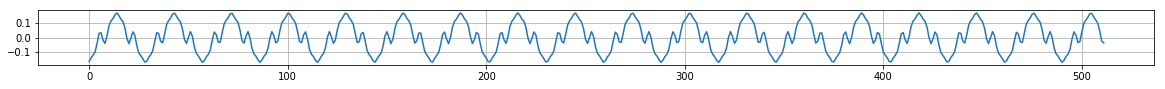

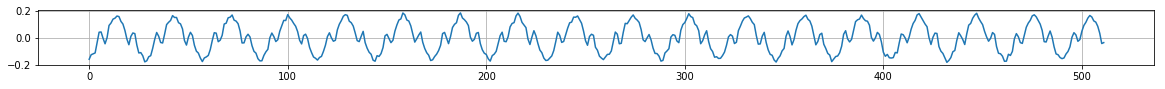

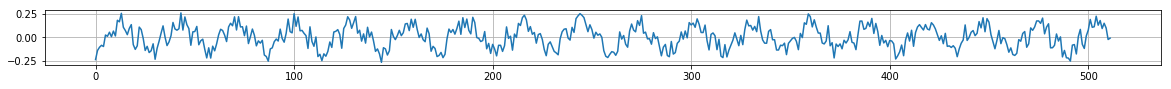

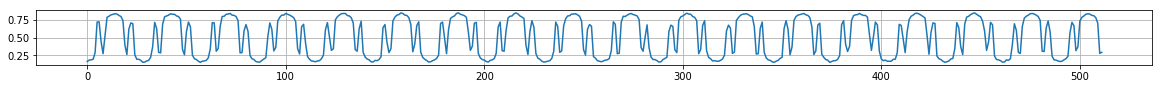

tensor([[0.9647, 1.0000, 0.9583, 0.4167],
        [0.9529, 1.0000, 0.9583, 0.4167],
        [0.9294, 1.0000, 0.9583, 0.4167],
        ...,
        [0.9686, 1.0000, 0.9583, 0.4167],
        [0.9412, 1.0000, 0.9583, 0.4167],
        [0.9412, 1.0000, 0.9583, 0.4167]])


In [12]:
#Just to visualize the audio encoding in dataloader

print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

# first pick a section of audio from the dataset
samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

#now inject noise weighted by the signal amplitude (to get roughly constant signal-to-noise ratio across data samples)
samp2 = samp + 0.1 * np.random.uniform(samp.min(), samp.max(), size=len(samp)).reshape(-1,1)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp2)), samp2) #just print one example from the batch
plt.grid()
plt.show()

#if required the noise can be fixed as well (constant=True) - see injectNoise() in transforms.py
samp3 = samp + 0.1 * np.random.uniform(-1, 1, size=len(samp)).reshape(-1,1)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp3)), samp3) #just print one example from the batch
plt.grid()
plt.show()

#we then encode the sampling to mu-law
samp_coded = audiocoding(samp2)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp_coded)), samp_coded) #just print one example from the batch
plt.grid()
plt.show()

for step, (inp,target) in enumerate(train_loader):
        print(inp[0])
        break

In [5]:
# Define the training cycle
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    ave_loss_over_steps = 0
    current_loss = 10000 #set at a large initial value 
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)

        # Forward + Backward + Optimize
        hidden = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio or i==0 else False
            #similar to Bengio et al, Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
            
            if use_teacher_forcing: #feed the target as the next input 
                outputs, hidden = model(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation detach()
                predicted_sample = targetcoding.index2float(topi)
                
            else: #feed its own predictions (output of t-1) as next input
                own_inp = inp[:,i,:].clone()
                own_inp[:,0] = torch.squeeze(torch.tensor(audiocoding(predicted_sample),
                                                          dtype=torch.float,device=device,requires_grad=True),1)
                outputs, hidden = model(own_inp,hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation
                predicted_sample = targetcoding.index2float(topi)
                           
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            current_loss = ave_loss_over_steps/log_interval
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch, num_epochs, step+1, len(adataset)//batch_size, current_loss))
            
            list_of_losses.append(current_loss)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result, hs = generate(model,max_length)
            plot_signal(result,start=seqLen-1)
            model.train() #put model back to training mode
        
        if savemodel_interval != 0 and savemodel:
            if (step+1) % savemodel_interval == 0:
                torch.save({ #the training parameters that will be saved
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': list_of_losses,
                'epoch': start_epoch+epoch,
                'step': start_step+step+1,
                'sample_rate': sr,
                'start_time': start,
                'datadir': datadir,
                'paramdir': paramdir,
                'savemodeldir': savemodeldir,
                'seqLen': seqLen,
                'stride': stride,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'lr': lr,
                'log_interval': log_interval,
                'max_steps': max_steps,
                'teacher_forcing_ratio': teacher_forcing_ratio,                    
                'prop': prop,
                'output_size': output_size,
                'hidden_size': hidden_size,
                'n_layers': n_layers,
                'noise': noise,
                'lowNote': lowNote,
                'hiNote': hiNote
                },                            
                '{}/{}_{}_epoch{}_step{}.tar'.format(
                    savemodeldir,start,savename,start_epoch+epoch,start_step+step+1))
                
                print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step+step+1))

        
        if step==max_steps or current_loss < loss_target:
            torch.save({ #the training parameters that will be saved
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': list_of_losses,
                'epoch': start_epoch+epoch,
                'step': start_step+step+1,
                'sample_rate': sr,
                'start_time': start,
                'datadir': datadir,
                'paramdir': paramdir,
                'savemodeldir': savemodeldir,
                'seqLen': seqLen,
                'stride': stride,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'lr': lr,
                'log_interval': log_interval,
                'max_steps': max_steps,
                'teacher_forcing_ratio': teacher_forcing_ratio,                    
                'prop': prop,
                'output_size': output_size,
                'hidden_size': hidden_size,
                'n_layers': n_layers,
                'noise': noise,
                'lowNote': lowNote,
                'hiNote': hiNote
                },                            
            '{}/{}_{}_epoch{}_step{}.tar'.format(
                savemodeldir,start,savename,start_epoch+epoch,start_step+step+1))

            print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step+step+1))
            break
 

 
def generate(model,max_length,primer=None,paramvect=None,returnHiddenSequence=False):
    
    hs=[] #list to save hidden states, function returns empty list if returnHiddenSequence=False 
    
    model.eval()
    with torch.no_grad():
        for p_inp,target in test_loader:
            if primer is not None:
                # must clone else primer is changed outside this function
                p_inp.data = primer.clone()
            seq = np.copy(p_inp[0,:,0])  #extract the original sample
            seq_mu = audiocoding(seq)  #mu-law
            p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
            break  
        generated = seq
        p_inp = p_inp.to(device)

        hidden = model.init_hidden().to(device)
        if returnHiddenSequence :
            hs.append(torch.squeeze(hidden).cpu().numpy())
        
        if p_inp.shape[1] > 1: #if priming with something with len>1
            for j in range(p_inp.shape[1]-1):  #build up hidden state
                _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device)
            if paramvect is not None:
                if callable(paramvect):
                    inp[:,1:] = torch.from_numpy(paramvect(i)).type(torch.FloatTensor).to(device)
                else:
                    inp[:,1:] = torch.from_numpy(paramvect).type(torch.FloatTensor).to(device)
                
            if returnHiddenSequence :
                hs.append(torch.squeeze(hidden).cpu().numpy())
                                       
        return generated, hs
        

In [6]:
# Initialize the network, optimizer and objective func
#*************************************
model = RNN(input_size=1,cond_size=cond_size,hidden_size=hidden_size,output_size=output_size,n_layers=n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if loadmodel: # load checkpoint if needed
    print("Loading existing model and optimizer state...")
    model.load_state_dict(torch.load(loadmodelpath, map_location=device)['model_state_dict'])
    optimizer.load_state_dict(torch.load(loadmodelpath, map_location=device)['optimizer_state_dict'])
    
criterion = nn.CrossEntropyLoss()

2019-01-27 10:43:18 Starting training at epoch0 step0...
2019-01-27 10:44:41 Epoch [0/1], Step [50/121875] Loss: 5.0710
2019-01-27 10:45:59 Epoch [0/1], Step [100/121875] Loss: 4.4634
2019-01-27 10:47:18 Epoch [0/1], Step [150/121875] Loss: 3.8770
2019-01-27 10:48:36 Epoch [0/1], Step [200/121875] Loss: 3.4687


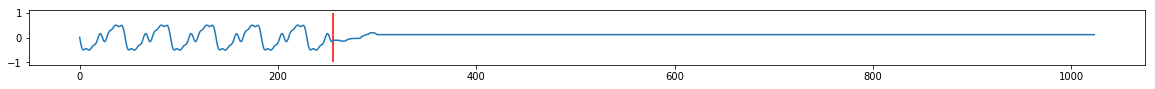

2019-01-27 10:49:59 Epoch [0/1], Step [250/121875] Loss: 3.1733
2019-01-27 10:51:16 Epoch [0/1], Step [300/121875] Loss: 2.9994
2019-01-27 10:52:33 Epoch [0/1], Step [350/121875] Loss: 2.8460
2019-01-27 10:53:49 Epoch [0/1], Step [400/121875] Loss: 2.8421


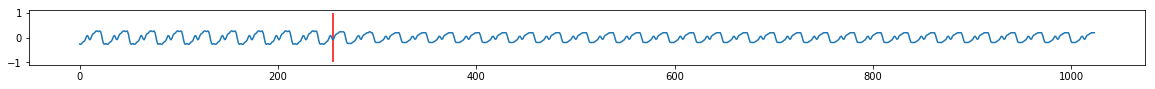

2019-01-27 10:55:11 Epoch [0/1], Step [450/121875] Loss: 2.7002
2019-01-27 10:56:28 Epoch [0/1], Step [500/121875] Loss: 2.6035
2019-01-27 10:57:44 Epoch [0/1], Step [550/121875] Loss: 2.5265
2019-01-27 10:59:00 Epoch [0/1], Step [600/121875] Loss: 2.4871


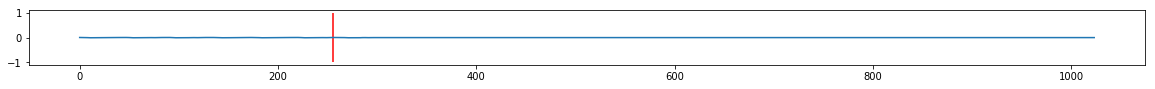

2019-01-27 11:00:23 Epoch [0/1], Step [650/121875] Loss: 2.5069
2019-01-27 11:01:40 Epoch [0/1], Step [700/121875] Loss: 2.3858
2019-01-27 11:02:57 Epoch [0/1], Step [750/121875] Loss: 2.3698
2019-01-27 11:04:15 Epoch [0/1], Step [800/121875] Loss: 2.2938


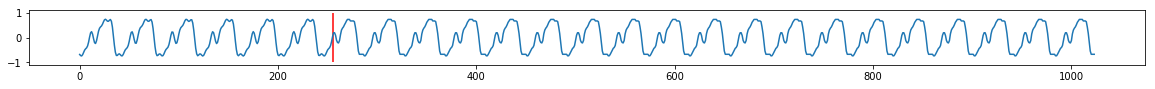

2019-01-27 11:05:39 Epoch [0/1], Step [850/121875] Loss: 2.3209
2019-01-27 11:06:57 Epoch [0/1], Step [900/121875] Loss: 2.2312
2019-01-27 11:08:15 Epoch [0/1], Step [950/121875] Loss: 2.2099
2019-01-27 11:09:34 Epoch [0/1], Step [1000/121875] Loss: 2.2071


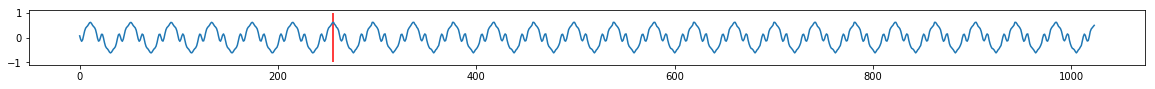

2019-01-27 11:10:57 Epoch [0/1], Step [1050/121875] Loss: 2.1582
2019-01-27 11:12:15 Epoch [0/1], Step [1100/121875] Loss: 2.1612
2019-01-27 11:13:33 Epoch [0/1], Step [1150/121875] Loss: 2.0894
2019-01-27 11:14:51 Epoch [0/1], Step [1200/121875] Loss: 2.1945


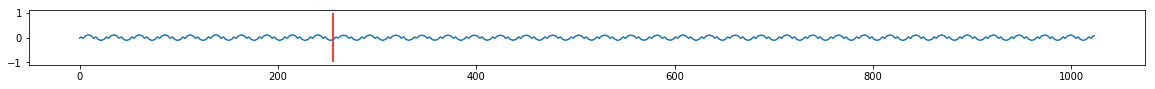

2019-01-27 11:16:14 Epoch [0/1], Step [1250/121875] Loss: 2.1619
2019-01-27 11:17:32 Epoch [0/1], Step [1300/121875] Loss: 2.0339
2019-01-27 11:18:50 Epoch [0/1], Step [1350/121875] Loss: 2.0430
2019-01-27 11:20:08 Epoch [0/1], Step [1400/121875] Loss: 2.0202


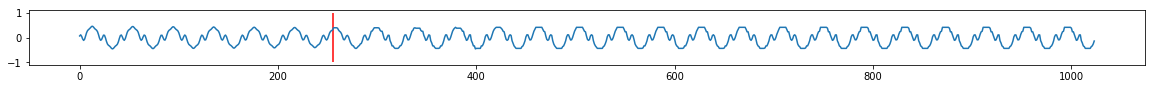

2019-01-27 11:21:31 Epoch [0/1], Step [1450/121875] Loss: 2.0054
2019-01-27 11:22:49 Epoch [0/1], Step [1500/121875] Loss: 2.1311
2019-01-27 11:24:07 Epoch [0/1], Step [1550/121875] Loss: 2.1477
2019-01-27 11:25:25 Epoch [0/1], Step [1600/121875] Loss: 1.9374


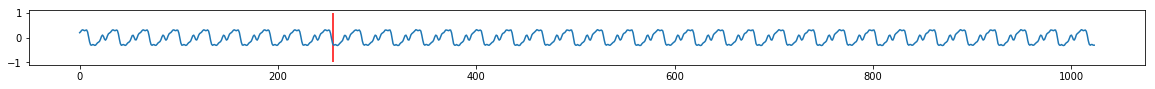

2019-01-27 11:26:48 Epoch [0/1], Step [1650/121875] Loss: 1.9273
2019-01-27 11:28:04 Epoch [0/1], Step [1700/121875] Loss: 1.9365
2019-01-27 11:29:22 Epoch [0/1], Step [1750/121875] Loss: 1.9305
2019-01-27 11:30:40 Epoch [0/1], Step [1800/121875] Loss: 1.9012


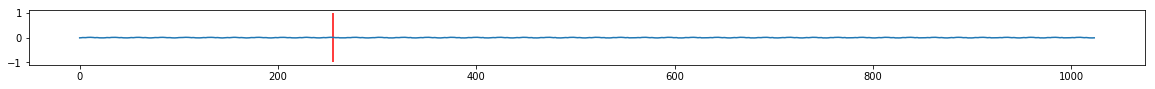

2019-01-27 11:32:01 Epoch [0/1], Step [1850/121875] Loss: 1.8979
2019-01-27 11:33:17 Epoch [0/1], Step [1900/121875] Loss: 1.8935
2019-01-27 11:34:34 Epoch [0/1], Step [1950/121875] Loss: 1.8826
2019-01-27 11:35:50 Epoch [0/1], Step [2000/121875] Loss: 1.9461


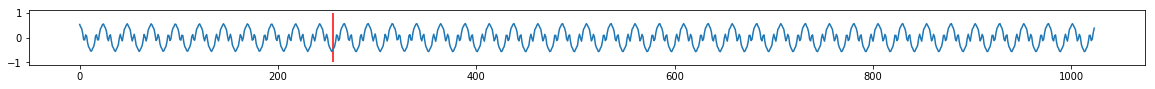

model 2019-01-27_10-43-18_model_epoch0_step2000.tar saved
2019-01-27 11:37:12 Epoch [0/1], Step [2050/121875] Loss: 1.8544
2019-01-27 11:38:28 Epoch [0/1], Step [2100/121875] Loss: 1.8514
2019-01-27 11:39:44 Epoch [0/1], Step [2150/121875] Loss: 1.8548
2019-01-27 11:41:02 Epoch [0/1], Step [2200/121875] Loss: 1.8395


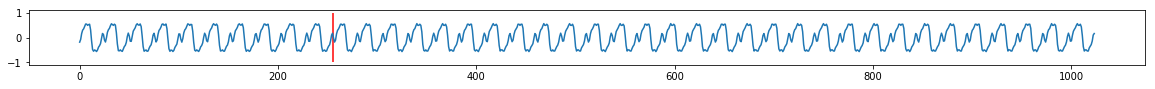

2019-01-27 11:42:26 Epoch [0/1], Step [2250/121875] Loss: 1.8335
2019-01-27 11:43:42 Epoch [0/1], Step [2300/121875] Loss: 1.8167
2019-01-27 11:44:59 Epoch [0/1], Step [2350/121875] Loss: 1.8219
2019-01-27 11:46:17 Epoch [0/1], Step [2400/121875] Loss: 1.8573


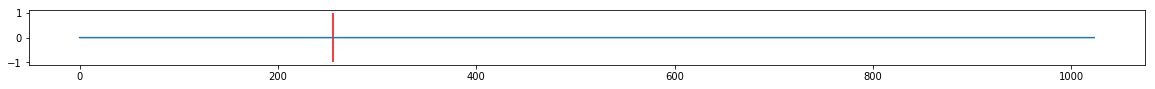

2019-01-27 11:47:41 Epoch [0/1], Step [2450/121875] Loss: 1.7993
2019-01-27 11:48:59 Epoch [0/1], Step [2500/121875] Loss: 1.7939
2019-01-27 11:50:20 Epoch [0/1], Step [2550/121875] Loss: 1.7645
2019-01-27 11:51:37 Epoch [0/1], Step [2600/121875] Loss: 1.8113


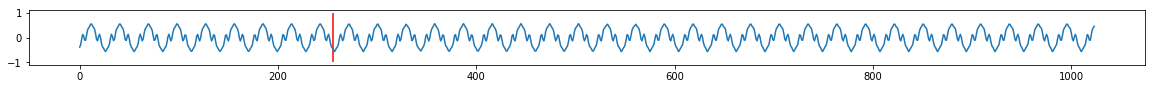

2019-01-27 11:53:00 Epoch [0/1], Step [2650/121875] Loss: 1.7752
2019-01-27 11:54:17 Epoch [0/1], Step [2700/121875] Loss: 1.8190
2019-01-27 11:55:34 Epoch [0/1], Step [2750/121875] Loss: 1.8146
2019-01-27 11:56:50 Epoch [0/1], Step [2800/121875] Loss: 1.7450


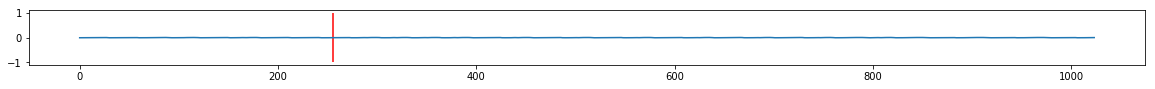

2019-01-27 11:58:11 Epoch [0/1], Step [2850/121875] Loss: 1.7698
2019-01-27 11:59:27 Epoch [0/1], Step [2900/121875] Loss: 1.7215
2019-01-27 12:00:44 Epoch [0/1], Step [2950/121875] Loss: 1.7418
2019-01-27 12:02:01 Epoch [0/1], Step [3000/121875] Loss: 1.7165


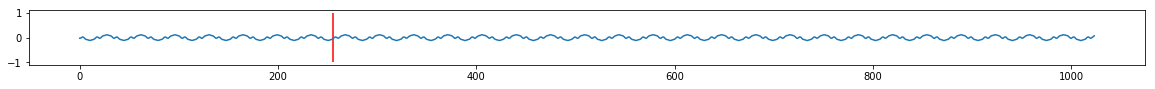

2019-01-27 12:03:22 Epoch [0/1], Step [3050/121875] Loss: 1.7492
2019-01-27 12:04:38 Epoch [0/1], Step [3100/121875] Loss: 1.7630
2019-01-27 12:05:55 Epoch [0/1], Step [3150/121875] Loss: 1.7154
2019-01-27 12:07:11 Epoch [0/1], Step [3200/121875] Loss: 1.6788


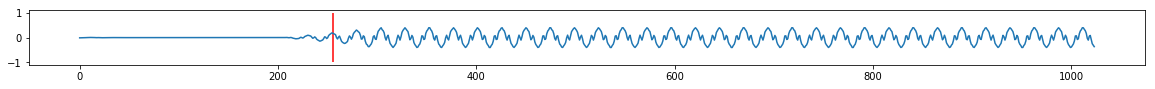

2019-01-27 12:08:32 Epoch [0/1], Step [3250/121875] Loss: 1.8492
2019-01-27 12:09:50 Epoch [0/1], Step [3300/121875] Loss: 1.7276
2019-01-27 12:11:27 Epoch [0/1], Step [3350/121875] Loss: 1.6767
2019-01-27 12:12:53 Epoch [0/1], Step [3400/121875] Loss: 1.6763


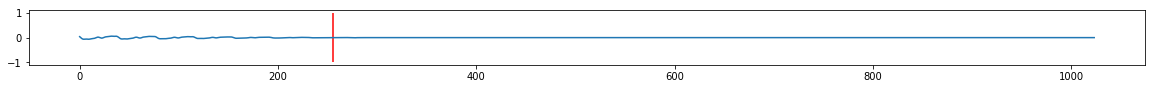

2019-01-27 12:14:20 Epoch [0/1], Step [3450/121875] Loss: 1.6737
2019-01-27 12:15:44 Epoch [0/1], Step [3500/121875] Loss: 1.6730
2019-01-27 12:17:05 Epoch [0/1], Step [3550/121875] Loss: 1.6697
2019-01-27 12:18:27 Epoch [0/1], Step [3600/121875] Loss: 1.7504


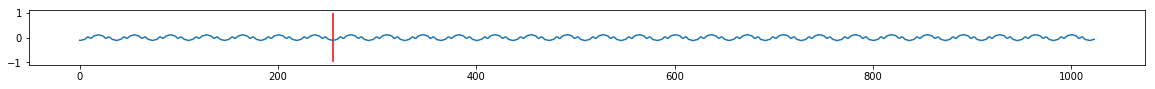

2019-01-27 12:19:56 Epoch [0/1], Step [3650/121875] Loss: 1.6558
2019-01-27 12:21:15 Epoch [0/1], Step [3700/121875] Loss: 1.6404
2019-01-27 12:22:38 Epoch [0/1], Step [3750/121875] Loss: 1.6439
2019-01-27 12:23:58 Epoch [0/1], Step [3800/121875] Loss: 1.7040


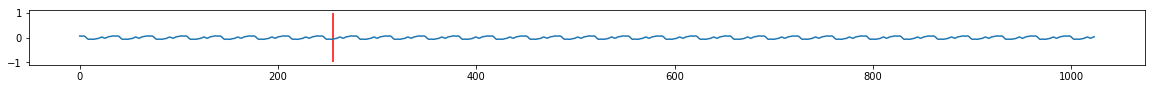

2019-01-27 12:25:22 Epoch [0/1], Step [3850/121875] Loss: 1.6983
2019-01-27 12:26:44 Epoch [0/1], Step [3900/121875] Loss: 1.6514
2019-01-27 12:28:06 Epoch [0/1], Step [3950/121875] Loss: 1.6384
2019-01-27 12:29:27 Epoch [0/1], Step [4000/121875] Loss: 1.6526


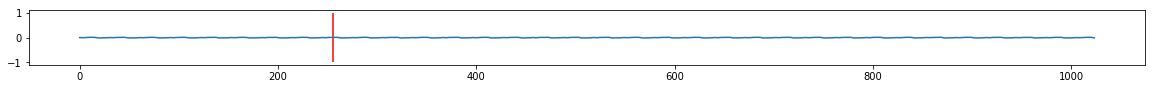

model 2019-01-27_10-43-18_model_epoch0_step4000.tar saved
2019-01-27 12:30:52 Epoch [0/1], Step [4050/121875] Loss: 1.6276
2019-01-27 12:32:15 Epoch [0/1], Step [4100/121875] Loss: 1.6921
2019-01-27 12:33:38 Epoch [0/1], Step [4150/121875] Loss: 1.6594
2019-01-27 12:35:03 Epoch [0/1], Step [4200/121875] Loss: 1.6106


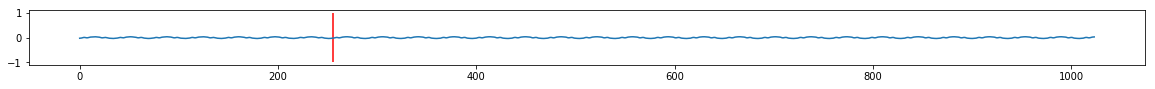

2019-01-27 12:36:29 Epoch [0/1], Step [4250/121875] Loss: 1.6154
2019-01-27 12:37:49 Epoch [0/1], Step [4300/121875] Loss: 1.6128
2019-01-27 12:39:13 Epoch [0/1], Step [4350/121875] Loss: 1.6534
2019-01-27 12:40:36 Epoch [0/1], Step [4400/121875] Loss: 1.6051


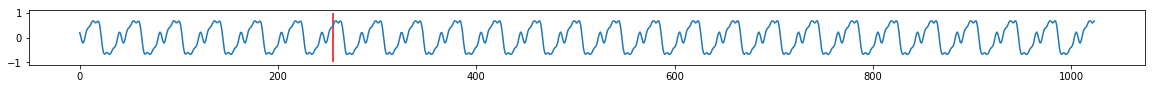

2019-01-27 12:42:03 Epoch [0/1], Step [4450/121875] Loss: 1.5968
2019-01-27 12:43:25 Epoch [0/1], Step [4500/121875] Loss: 1.6028
2019-01-27 12:44:50 Epoch [0/1], Step [4550/121875] Loss: 1.5973
2019-01-27 12:46:12 Epoch [0/1], Step [4600/121875] Loss: 1.6160


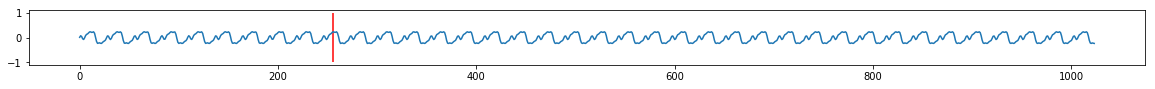

2019-01-27 12:47:39 Epoch [0/1], Step [4650/121875] Loss: 1.6252
2019-01-27 12:49:01 Epoch [0/1], Step [4700/121875] Loss: 1.5699
2019-01-27 12:50:24 Epoch [0/1], Step [4750/121875] Loss: 1.5918
2019-01-27 12:51:45 Epoch [0/1], Step [4800/121875] Loss: 1.6142


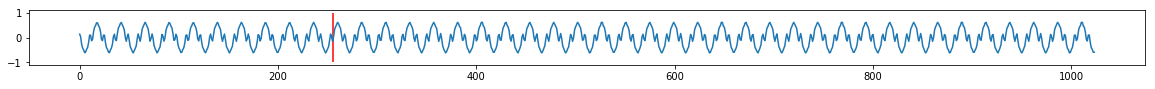

2019-01-27 12:53:11 Epoch [0/1], Step [4850/121875] Loss: 1.5741
2019-01-27 12:54:28 Epoch [0/1], Step [4900/121875] Loss: 1.5778
2019-01-27 12:55:45 Epoch [0/1], Step [4950/121875] Loss: 1.5984
2019-01-27 12:57:03 Epoch [0/1], Step [5000/121875] Loss: 1.6267


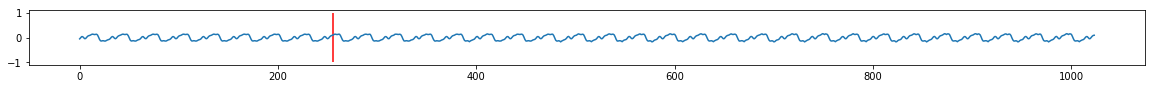

2019-01-27 12:58:25 Epoch [0/1], Step [5050/121875] Loss: 1.5953
2019-01-27 12:59:43 Epoch [0/1], Step [5100/121875] Loss: 1.5461
2019-01-27 13:01:00 Epoch [0/1], Step [5150/121875] Loss: 1.5347
2019-01-27 13:02:16 Epoch [0/1], Step [5200/121875] Loss: 1.5747


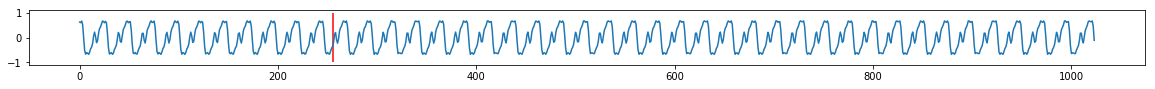

2019-01-27 13:03:39 Epoch [0/1], Step [5250/121875] Loss: 2.4581
2019-01-27 13:04:56 Epoch [0/1], Step [5300/121875] Loss: 1.7918
2019-01-27 13:06:13 Epoch [0/1], Step [5350/121875] Loss: 1.6957
2019-01-27 13:07:30 Epoch [0/1], Step [5400/121875] Loss: 1.6343


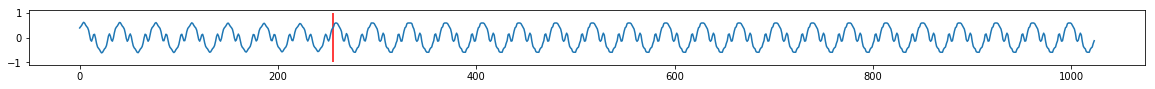

2019-01-27 13:08:52 Epoch [0/1], Step [5450/121875] Loss: 1.6304
2019-01-27 13:10:09 Epoch [0/1], Step [5500/121875] Loss: 1.6392
2019-01-27 13:11:26 Epoch [0/1], Step [5550/121875] Loss: 1.5991
2019-01-27 13:12:44 Epoch [0/1], Step [5600/121875] Loss: 1.5887


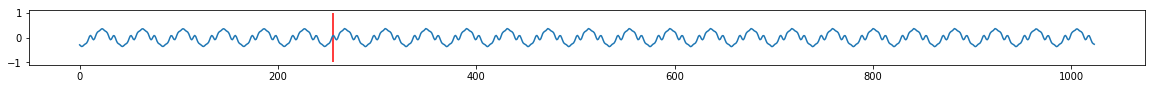

2019-01-27 13:14:09 Epoch [0/1], Step [5650/121875] Loss: 1.5913
2019-01-27 13:15:28 Epoch [0/1], Step [5700/121875] Loss: 1.5914
2019-01-27 13:16:50 Epoch [0/1], Step [5750/121875] Loss: 1.5411
2019-01-27 13:18:09 Epoch [0/1], Step [5800/121875] Loss: 1.5494


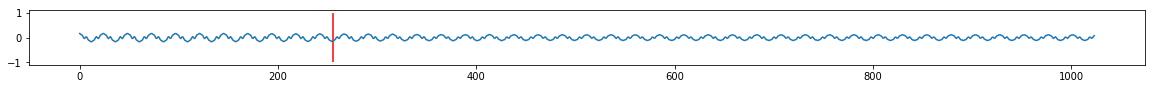

2019-01-27 13:19:32 Epoch [0/1], Step [5850/121875] Loss: 1.6066
2019-01-27 13:20:51 Epoch [0/1], Step [5900/121875] Loss: 1.5596
2019-01-27 13:22:10 Epoch [0/1], Step [5950/121875] Loss: 1.5790
2019-01-27 13:23:29 Epoch [0/1], Step [6000/121875] Loss: 1.5634


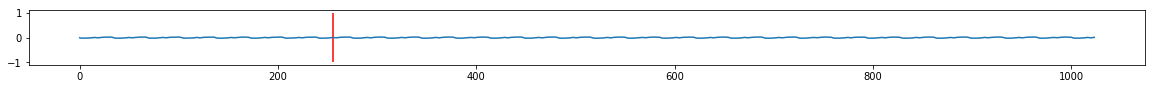

model 2019-01-27_10-43-18_model_epoch0_step6000.tar saved
2019-01-27 13:24:55 Epoch [0/1], Step [6050/121875] Loss: 1.5466
2019-01-27 13:26:14 Epoch [0/1], Step [6100/121875] Loss: 1.5567
2019-01-27 13:27:33 Epoch [0/1], Step [6150/121875] Loss: 1.5442
2019-01-27 13:28:52 Epoch [0/1], Step [6200/121875] Loss: 1.5333


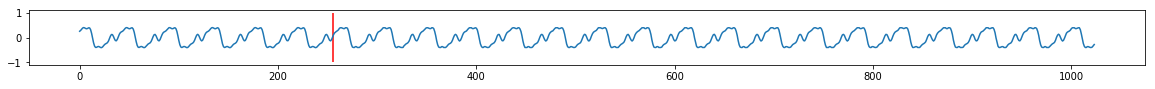

2019-01-27 13:30:15 Epoch [0/1], Step [6250/121875] Loss: 1.5558
2019-01-27 13:31:33 Epoch [0/1], Step [6300/121875] Loss: 1.5536
2019-01-27 13:32:51 Epoch [0/1], Step [6350/121875] Loss: 1.5864
2019-01-27 13:34:10 Epoch [0/1], Step [6400/121875] Loss: 1.5262


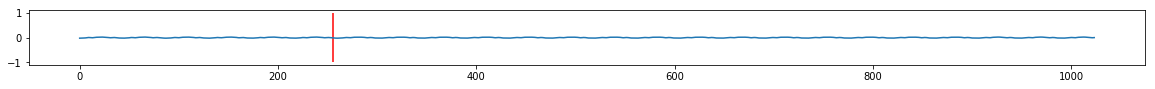

2019-01-27 13:35:36 Epoch [0/1], Step [6450/121875] Loss: 1.5104
2019-01-27 13:36:59 Epoch [0/1], Step [6500/121875] Loss: 1.5500
2019-01-27 13:38:22 Epoch [0/1], Step [6550/121875] Loss: 1.4882
2019-01-27 13:39:42 Epoch [0/1], Step [6600/121875] Loss: 1.4989


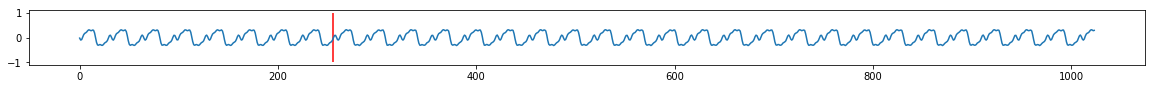

2019-01-27 13:41:08 Epoch [0/1], Step [6650/121875] Loss: 1.5260
2019-01-27 13:42:30 Epoch [0/1], Step [6700/121875] Loss: 1.4909
2019-01-27 13:44:00 Epoch [0/1], Step [6750/121875] Loss: 1.5053
2019-01-27 13:45:24 Epoch [0/1], Step [6800/121875] Loss: 1.5255


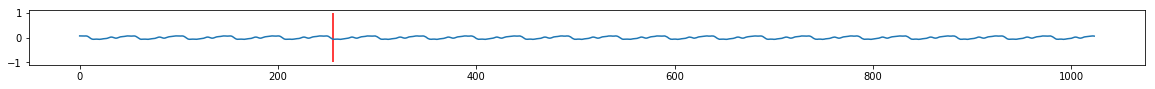

2019-01-27 13:46:53 Epoch [0/1], Step [6850/121875] Loss: 1.5626
2019-01-27 13:48:11 Epoch [0/1], Step [6900/121875] Loss: 1.5065
2019-01-27 13:49:30 Epoch [0/1], Step [6950/121875] Loss: 1.5032
2019-01-27 13:50:49 Epoch [0/1], Step [7000/121875] Loss: 1.4966


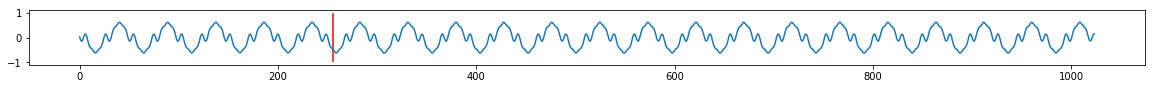

2019-01-27 13:52:13 Epoch [0/1], Step [7050/121875] Loss: 1.5670
2019-01-27 13:53:33 Epoch [0/1], Step [7100/121875] Loss: 1.4954
2019-01-27 13:54:51 Epoch [0/1], Step [7150/121875] Loss: 1.4913
2019-01-27 13:56:11 Epoch [0/1], Step [7200/121875] Loss: 1.4823


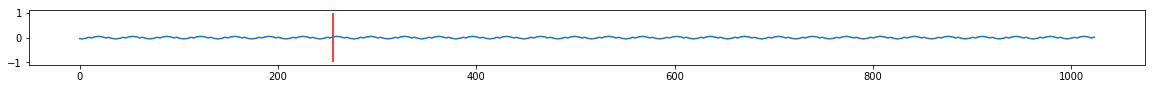

2019-01-27 13:57:35 Epoch [0/1], Step [7250/121875] Loss: 1.4845
2019-01-27 13:58:53 Epoch [0/1], Step [7300/121875] Loss: 1.5351
2019-01-27 14:00:22 Epoch [0/1], Step [7350/121875] Loss: 1.5396
2019-01-27 14:01:39 Epoch [0/1], Step [7400/121875] Loss: 1.4751


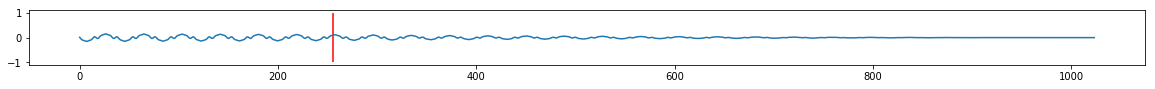

2019-01-27 14:03:03 Epoch [0/1], Step [7450/121875] Loss: 1.4704
2019-01-27 14:04:20 Epoch [0/1], Step [7500/121875] Loss: 1.4730
2019-01-27 14:05:39 Epoch [0/1], Step [7550/121875] Loss: 1.5126
2019-01-27 14:07:01 Epoch [0/1], Step [7600/121875] Loss: 1.4643


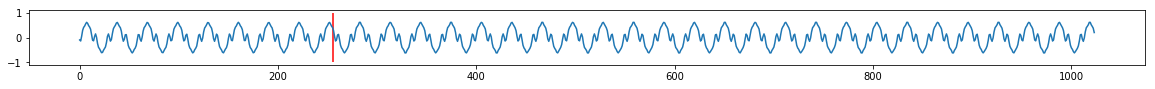

2019-01-27 14:08:23 Epoch [0/1], Step [7650/121875] Loss: 1.4929
2019-01-27 14:09:45 Epoch [0/1], Step [7700/121875] Loss: 1.5673
2019-01-27 14:11:07 Epoch [0/1], Step [7750/121875] Loss: 1.4636
2019-01-27 14:12:29 Epoch [0/1], Step [7800/121875] Loss: 1.4394


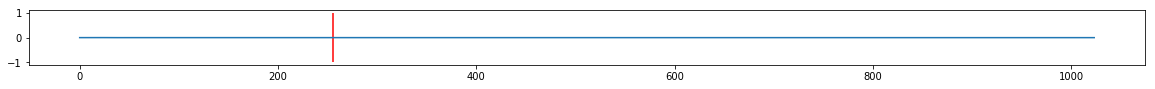

2019-01-27 14:13:55 Epoch [0/1], Step [7850/121875] Loss: 1.4634
2019-01-27 14:15:16 Epoch [0/1], Step [7900/121875] Loss: 1.4552
2019-01-27 14:16:33 Epoch [0/1], Step [7950/121875] Loss: 1.5124
2019-01-27 14:17:50 Epoch [0/1], Step [8000/121875] Loss: 1.4630


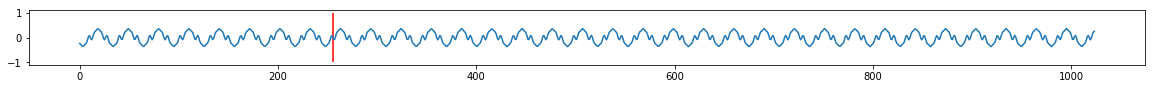

model 2019-01-27_10-43-18_model_epoch0_step8000.tar saved
2019-01-27 14:19:13 Epoch [0/1], Step [8050/121875] Loss: 1.4445
2019-01-27 14:20:30 Epoch [0/1], Step [8100/121875] Loss: 1.6521
2019-01-27 14:21:47 Epoch [0/1], Step [8150/121875] Loss: 1.5765
2019-01-27 14:23:04 Epoch [0/1], Step [8200/121875] Loss: 1.4746


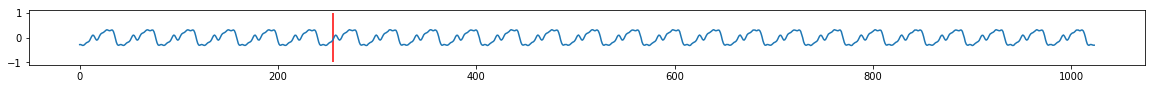

2019-01-27 14:24:26 Epoch [0/1], Step [8250/121875] Loss: 1.4657
2019-01-27 14:25:43 Epoch [0/1], Step [8300/121875] Loss: 1.4494
2019-01-27 14:27:00 Epoch [0/1], Step [8350/121875] Loss: 1.4479
2019-01-27 14:28:17 Epoch [0/1], Step [8400/121875] Loss: 1.4227


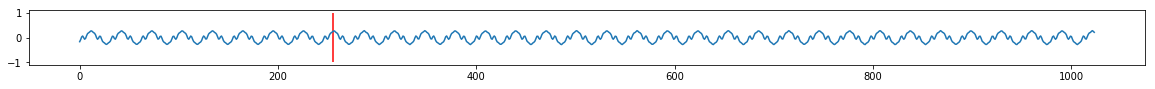

2019-01-27 14:29:39 Epoch [0/1], Step [8450/121875] Loss: 1.4341
2019-01-27 14:30:57 Epoch [0/1], Step [8500/121875] Loss: 1.4725
2019-01-27 14:32:13 Epoch [0/1], Step [8550/121875] Loss: 1.4404
2019-01-27 14:33:30 Epoch [0/1], Step [8600/121875] Loss: 1.5376


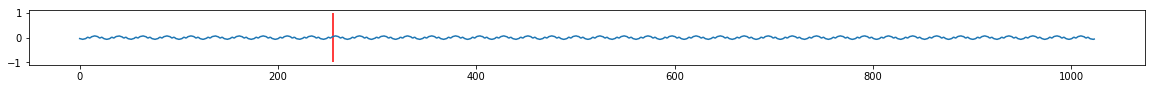

2019-01-27 14:34:52 Epoch [0/1], Step [8650/121875] Loss: 1.4027
2019-01-27 14:36:09 Epoch [0/1], Step [8700/121875] Loss: 1.5057
2019-01-27 14:37:27 Epoch [0/1], Step [8750/121875] Loss: 1.4266
2019-01-27 14:38:44 Epoch [0/1], Step [8800/121875] Loss: 1.4679


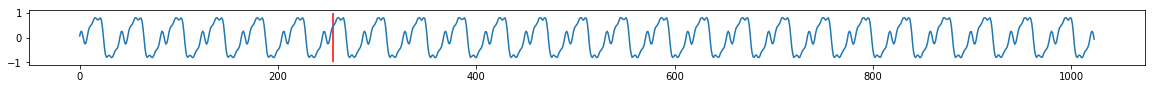

2019-01-27 14:40:06 Epoch [0/1], Step [8850/121875] Loss: 1.8775
2019-01-27 14:41:23 Epoch [0/1], Step [8900/121875] Loss: 1.4438
2019-01-27 14:42:40 Epoch [0/1], Step [8950/121875] Loss: 1.4133
2019-01-27 14:43:58 Epoch [0/1], Step [9000/121875] Loss: 1.4131


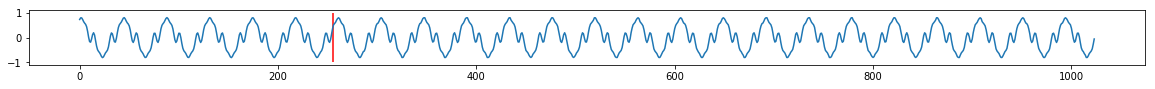

2019-01-27 14:45:20 Epoch [0/1], Step [9050/121875] Loss: 1.4415
2019-01-27 14:46:38 Epoch [0/1], Step [9100/121875] Loss: 1.4480
2019-01-27 14:47:55 Epoch [0/1], Step [9150/121875] Loss: 1.4429
2019-01-27 14:49:11 Epoch [0/1], Step [9200/121875] Loss: 1.4283


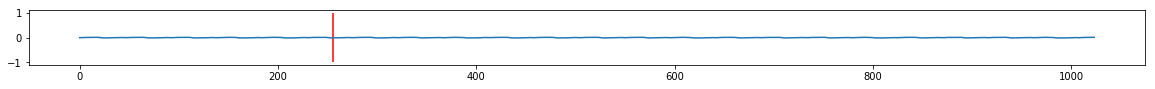

2019-01-27 14:50:34 Epoch [0/1], Step [9250/121875] Loss: 1.4103
2019-01-27 14:51:51 Epoch [0/1], Step [9300/121875] Loss: 1.4508
2019-01-27 14:53:08 Epoch [0/1], Step [9350/121875] Loss: 1.4057
2019-01-27 14:54:25 Epoch [0/1], Step [9400/121875] Loss: 1.4202


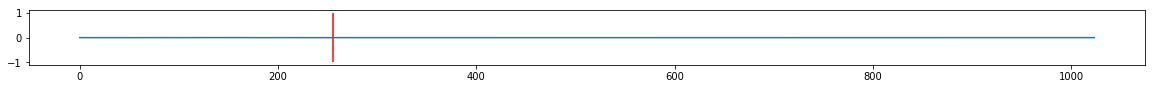

2019-01-27 14:55:47 Epoch [0/1], Step [9450/121875] Loss: 1.4254
2019-01-27 14:57:04 Epoch [0/1], Step [9500/121875] Loss: 1.4424
2019-01-27 14:58:21 Epoch [0/1], Step [9550/121875] Loss: 1.4894
2019-01-27 14:59:38 Epoch [0/1], Step [9600/121875] Loss: 1.5062


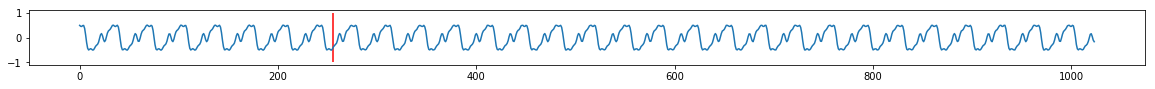

2019-01-27 15:01:00 Epoch [0/1], Step [9650/121875] Loss: 1.4114
2019-01-27 15:02:17 Epoch [0/1], Step [9700/121875] Loss: 1.4639
2019-01-27 15:03:34 Epoch [0/1], Step [9750/121875] Loss: 1.4346
2019-01-27 15:04:50 Epoch [0/1], Step [9800/121875] Loss: 1.4211


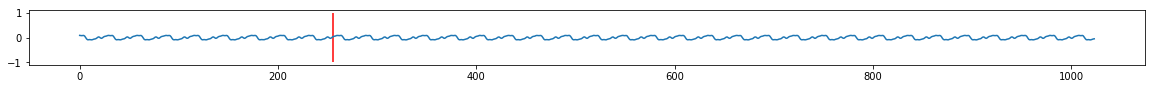

2019-01-27 15:06:12 Epoch [0/1], Step [9850/121875] Loss: 1.4060
2019-01-27 15:07:29 Epoch [0/1], Step [9900/121875] Loss: 1.4116
2019-01-27 15:08:46 Epoch [0/1], Step [9950/121875] Loss: 1.4111
2019-01-27 15:10:03 Epoch [0/1], Step [10000/121875] Loss: 1.4036


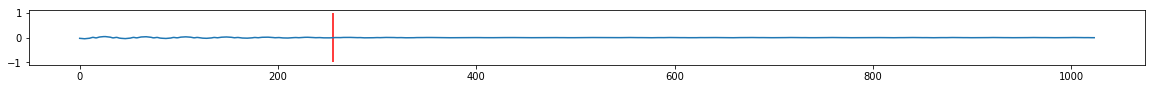

model 2019-01-27_10-43-18_model_epoch0_step10000.tar saved
2019-01-27 15:11:25 Epoch [0/1], Step [10050/121875] Loss: 1.4333
2019-01-27 15:12:42 Epoch [0/1], Step [10100/121875] Loss: 1.3764
2019-01-27 15:13:59 Epoch [0/1], Step [10150/121875] Loss: 1.4029
2019-01-27 15:15:16 Epoch [0/1], Step [10200/121875] Loss: 1.4224


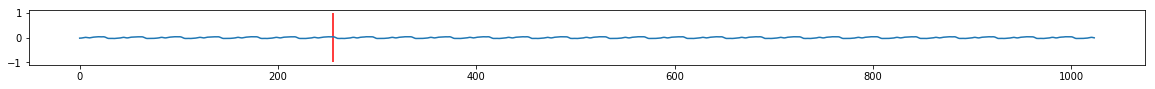

2019-01-27 15:16:39 Epoch [0/1], Step [10250/121875] Loss: 1.4228
2019-01-27 15:17:56 Epoch [0/1], Step [10300/121875] Loss: 1.4466
2019-01-27 15:19:13 Epoch [0/1], Step [10350/121875] Loss: 1.3723
2019-01-27 15:20:31 Epoch [0/1], Step [10400/121875] Loss: 1.5152


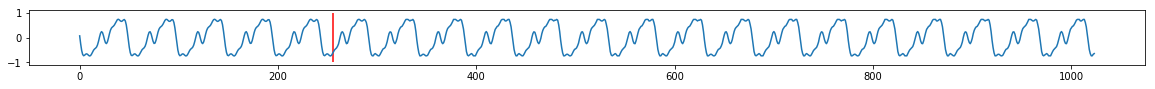

2019-01-27 15:21:53 Epoch [0/1], Step [10450/121875] Loss: 1.4284
2019-01-27 15:23:11 Epoch [0/1], Step [10500/121875] Loss: 1.3788
2019-01-27 15:24:28 Epoch [0/1], Step [10550/121875] Loss: 1.4055
2019-01-27 15:25:45 Epoch [0/1], Step [10600/121875] Loss: 1.4015


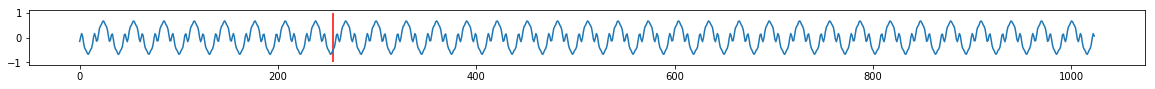

2019-01-27 15:27:08 Epoch [0/1], Step [10650/121875] Loss: 1.3959
2019-01-27 15:28:25 Epoch [0/1], Step [10700/121875] Loss: 1.4446
2019-01-27 15:29:42 Epoch [0/1], Step [10750/121875] Loss: 1.3735
2019-01-27 15:31:02 Epoch [0/1], Step [10800/121875] Loss: 1.4172


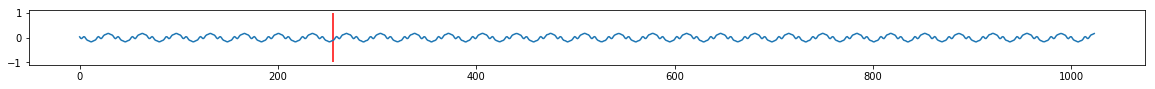

2019-01-27 15:32:35 Epoch [0/1], Step [10850/121875] Loss: 1.4109
2019-01-27 15:33:59 Epoch [0/1], Step [10900/121875] Loss: 1.3897
2019-01-27 15:35:19 Epoch [0/1], Step [10950/121875] Loss: 1.3777
2019-01-27 15:36:37 Epoch [0/1], Step [11000/121875] Loss: 1.4395


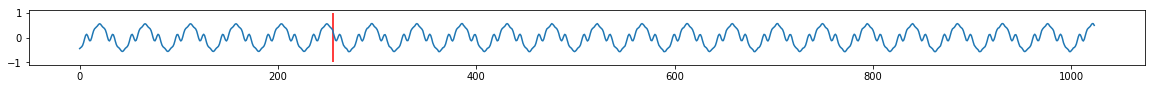

2019-01-27 15:37:59 Epoch [0/1], Step [11050/121875] Loss: 1.4166
2019-01-27 15:39:16 Epoch [0/1], Step [11100/121875] Loss: 1.4163
2019-01-27 15:40:33 Epoch [0/1], Step [11150/121875] Loss: 1.3708
2019-01-27 15:41:50 Epoch [0/1], Step [11200/121875] Loss: 1.3859


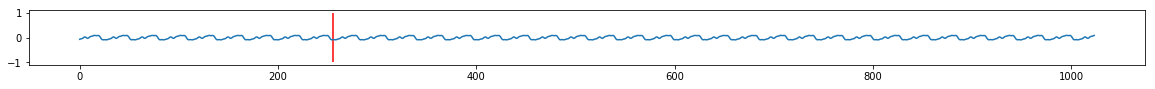

2019-01-27 15:43:13 Epoch [0/1], Step [11250/121875] Loss: 1.3921
2019-01-27 15:44:30 Epoch [0/1], Step [11300/121875] Loss: 1.3898
2019-01-27 15:45:47 Epoch [0/1], Step [11350/121875] Loss: 1.4069
2019-01-27 15:47:04 Epoch [0/1], Step [11400/121875] Loss: 1.3993


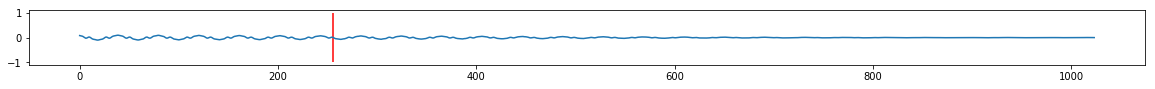

2019-01-27 15:48:26 Epoch [0/1], Step [11450/121875] Loss: 1.3966
2019-01-27 15:49:43 Epoch [0/1], Step [11500/121875] Loss: 1.4292
2019-01-27 15:51:00 Epoch [0/1], Step [11550/121875] Loss: 1.9196
2019-01-27 15:52:17 Epoch [0/1], Step [11600/121875] Loss: 1.4572


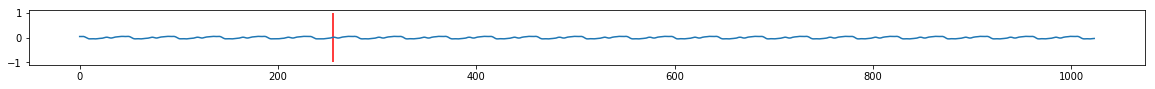

2019-01-27 15:53:39 Epoch [0/1], Step [11650/121875] Loss: 1.4126
2019-01-27 15:54:56 Epoch [0/1], Step [11700/121875] Loss: 1.4608
2019-01-27 15:56:13 Epoch [0/1], Step [11750/121875] Loss: 1.4310
2019-01-27 15:57:31 Epoch [0/1], Step [11800/121875] Loss: 1.3805


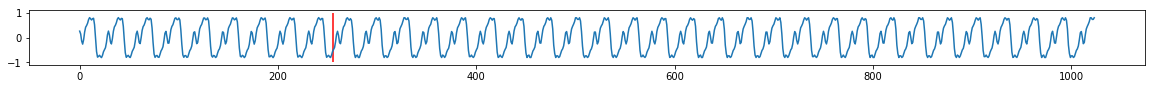

2019-01-27 15:58:53 Epoch [0/1], Step [11850/121875] Loss: 1.4062
2019-01-27 16:00:12 Epoch [0/1], Step [11900/121875] Loss: 1.3972
2019-01-27 16:01:31 Epoch [0/1], Step [11950/121875] Loss: 1.3925
2019-01-27 16:02:49 Epoch [0/1], Step [12000/121875] Loss: 1.3579


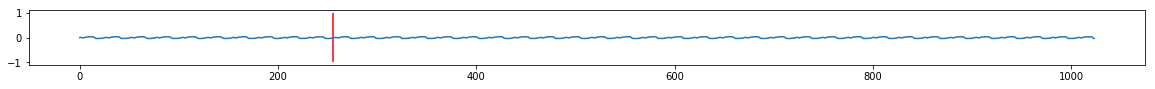

model 2019-01-27_10-43-18_model_epoch0_step12000.tar saved
2019-01-27 16:04:13 Epoch [0/1], Step [12050/121875] Loss: 1.3795
2019-01-27 16:05:31 Epoch [0/1], Step [12100/121875] Loss: 1.4023
2019-01-27 16:06:50 Epoch [0/1], Step [12150/121875] Loss: 1.3750
2019-01-27 16:08:10 Epoch [0/1], Step [12200/121875] Loss: 1.3723


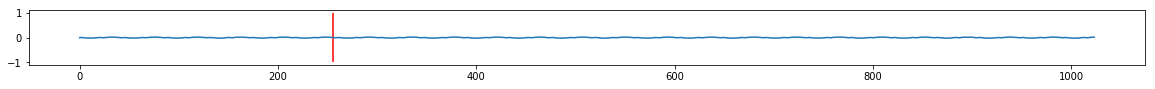

2019-01-27 16:09:35 Epoch [0/1], Step [12250/121875] Loss: 1.4011
2019-01-27 16:10:52 Epoch [0/1], Step [12300/121875] Loss: 1.3497
2019-01-27 16:12:14 Epoch [0/1], Step [12350/121875] Loss: 1.3991
2019-01-27 16:13:33 Epoch [0/1], Step [12400/121875] Loss: 1.3921


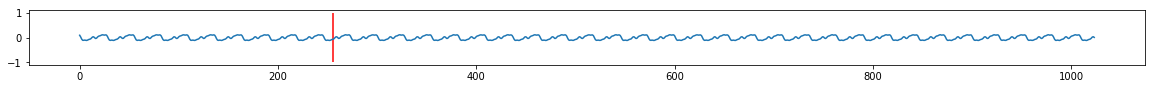

2019-01-27 16:14:57 Epoch [0/1], Step [12450/121875] Loss: 1.3545
2019-01-27 16:16:15 Epoch [0/1], Step [12500/121875] Loss: 1.4576
2019-01-27 16:17:34 Epoch [0/1], Step [12550/121875] Loss: 1.3345
2019-01-27 16:18:53 Epoch [0/1], Step [12600/121875] Loss: 1.3650


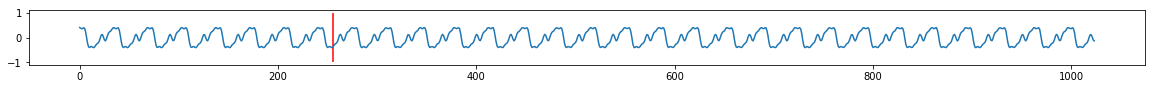

2019-01-27 16:20:17 Epoch [0/1], Step [12650/121875] Loss: 1.4151
2019-01-27 16:21:35 Epoch [0/1], Step [12700/121875] Loss: 1.3512
2019-01-27 16:22:54 Epoch [0/1], Step [12750/121875] Loss: 1.3620
2019-01-27 16:24:13 Epoch [0/1], Step [12800/121875] Loss: 1.3529


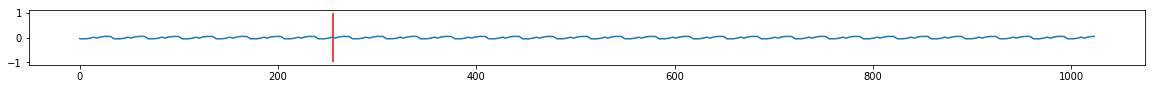

2019-01-27 16:25:38 Epoch [0/1], Step [12850/121875] Loss: 1.3783
2019-01-27 16:26:57 Epoch [0/1], Step [12900/121875] Loss: 1.3611
2019-01-27 16:28:15 Epoch [0/1], Step [12950/121875] Loss: 1.3655
2019-01-27 16:29:33 Epoch [0/1], Step [13000/121875] Loss: 1.3636


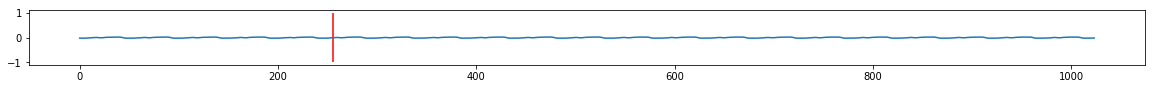

2019-01-27 16:30:56 Epoch [0/1], Step [13050/121875] Loss: 1.3744
2019-01-27 16:32:14 Epoch [0/1], Step [13100/121875] Loss: 1.3897
2019-01-27 16:33:32 Epoch [0/1], Step [13150/121875] Loss: 1.3571
2019-01-27 16:34:50 Epoch [0/1], Step [13200/121875] Loss: 1.3376


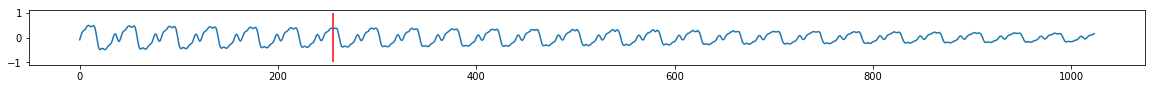

2019-01-27 16:36:13 Epoch [0/1], Step [13250/121875] Loss: 1.3585
2019-01-27 16:37:32 Epoch [0/1], Step [13300/121875] Loss: 1.3527
2019-01-27 16:38:50 Epoch [0/1], Step [13350/121875] Loss: 1.3582
2019-01-27 16:40:09 Epoch [0/1], Step [13400/121875] Loss: 1.3619


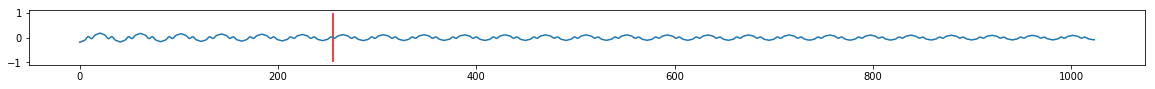

2019-01-27 16:41:33 Epoch [0/1], Step [13450/121875] Loss: 1.3569
2019-01-27 16:42:52 Epoch [0/1], Step [13500/121875] Loss: 1.3440
2019-01-27 16:44:11 Epoch [0/1], Step [13550/121875] Loss: 1.3575
2019-01-27 16:45:31 Epoch [0/1], Step [13600/121875] Loss: 1.3877


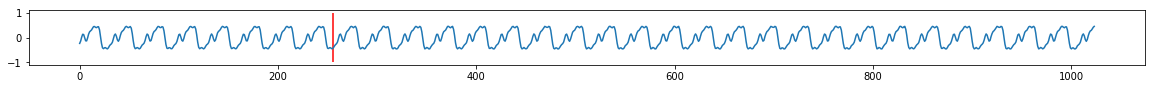

2019-01-27 16:46:59 Epoch [0/1], Step [13650/121875] Loss: 1.3276
2019-01-27 16:48:22 Epoch [0/1], Step [13700/121875] Loss: 1.3680
2019-01-27 16:49:45 Epoch [0/1], Step [13750/121875] Loss: 1.3761
2019-01-27 16:51:07 Epoch [0/1], Step [13800/121875] Loss: 1.3422


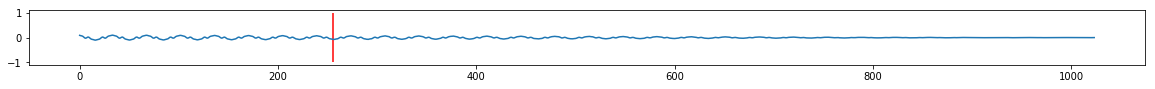

2019-01-27 16:52:36 Epoch [0/1], Step [13850/121875] Loss: 1.3383
2019-01-27 16:53:55 Epoch [0/1], Step [13900/121875] Loss: 1.3434
2019-01-27 16:55:14 Epoch [0/1], Step [13950/121875] Loss: 1.4250
2019-01-27 16:56:31 Epoch [0/1], Step [14000/121875] Loss: 1.3191


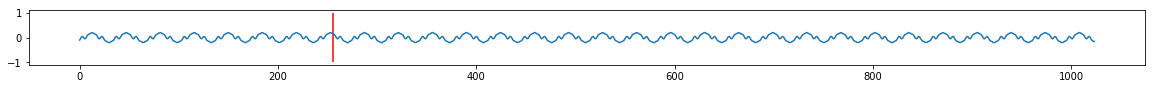

model 2019-01-27_10-43-18_model_epoch0_step14000.tar saved
2019-01-27 16:57:54 Epoch [0/1], Step [14050/121875] Loss: 1.3340
2019-01-27 16:59:11 Epoch [0/1], Step [14100/121875] Loss: 1.3267
2019-01-27 17:00:29 Epoch [0/1], Step [14150/121875] Loss: 1.3513
2019-01-27 17:01:46 Epoch [0/1], Step [14200/121875] Loss: 1.3324


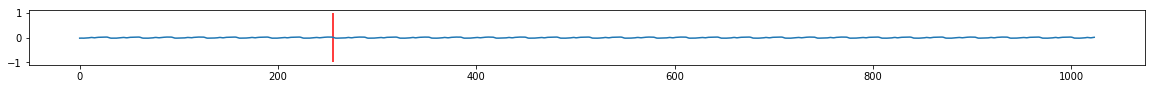

2019-01-27 17:03:08 Epoch [0/1], Step [14250/121875] Loss: 1.3392
2019-01-27 17:04:25 Epoch [0/1], Step [14300/121875] Loss: 1.3220
2019-01-27 17:05:42 Epoch [0/1], Step [14350/121875] Loss: 1.3912
2019-01-27 17:07:00 Epoch [0/1], Step [14400/121875] Loss: 1.3470


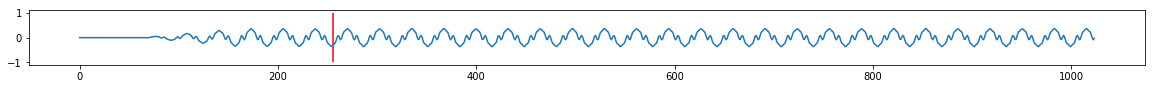

2019-01-27 17:08:22 Epoch [0/1], Step [14450/121875] Loss: 1.3608
2019-01-27 17:09:39 Epoch [0/1], Step [14500/121875] Loss: 1.3280
2019-01-27 17:10:56 Epoch [0/1], Step [14550/121875] Loss: 1.4173
2019-01-27 17:12:14 Epoch [0/1], Step [14600/121875] Loss: 1.3153


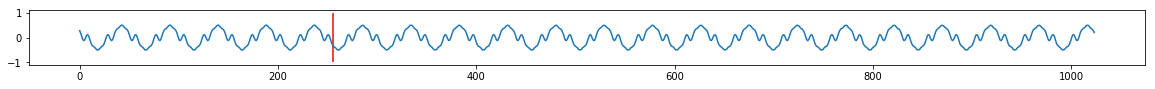

2019-01-27 17:13:37 Epoch [0/1], Step [14650/121875] Loss: 1.3274
2019-01-27 17:14:54 Epoch [0/1], Step [14700/121875] Loss: 1.3188
2019-01-27 17:16:11 Epoch [0/1], Step [14750/121875] Loss: 1.3720
2019-01-27 17:17:29 Epoch [0/1], Step [14800/121875] Loss: 1.3837


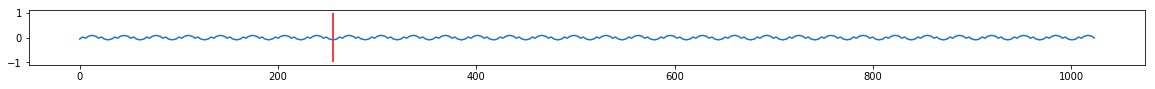

2019-01-27 17:18:51 Epoch [0/1], Step [14850/121875] Loss: 1.3330
2019-01-27 17:20:08 Epoch [0/1], Step [14900/121875] Loss: 1.3235
2019-01-27 17:21:25 Epoch [0/1], Step [14950/121875] Loss: 1.3265
2019-01-27 17:22:42 Epoch [0/1], Step [15000/121875] Loss: 1.3018


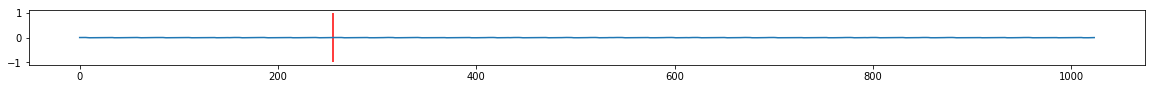

2019-01-27 17:24:05 Epoch [0/1], Step [15050/121875] Loss: 1.3644
2019-01-27 17:25:22 Epoch [0/1], Step [15100/121875] Loss: 1.3300
2019-01-27 17:26:39 Epoch [0/1], Step [15150/121875] Loss: 1.3245
2019-01-27 17:27:56 Epoch [0/1], Step [15200/121875] Loss: 1.2865


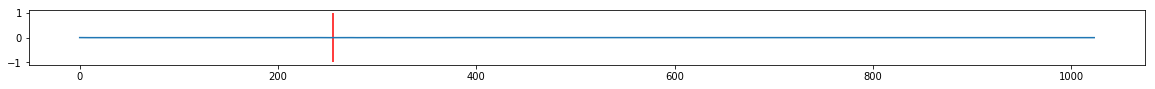

2019-01-27 17:29:19 Epoch [0/1], Step [15250/121875] Loss: 1.3329
2019-01-27 17:30:36 Epoch [0/1], Step [15300/121875] Loss: 1.3166
2019-01-27 17:31:53 Epoch [0/1], Step [15350/121875] Loss: 1.3638
2019-01-27 17:33:10 Epoch [0/1], Step [15400/121875] Loss: 1.3064


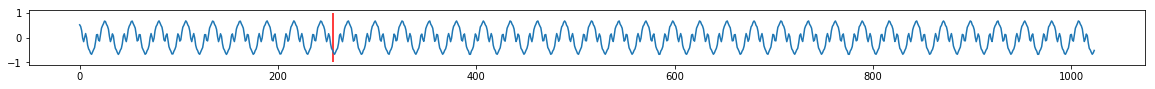

2019-01-27 17:34:33 Epoch [0/1], Step [15450/121875] Loss: 1.3105
2019-01-27 17:35:50 Epoch [0/1], Step [15500/121875] Loss: 1.3496
2019-01-27 17:37:07 Epoch [0/1], Step [15550/121875] Loss: 1.3161
2019-01-27 17:38:24 Epoch [0/1], Step [15600/121875] Loss: 1.3005


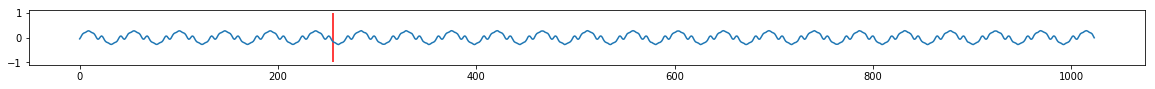

2019-01-27 17:39:46 Epoch [0/1], Step [15650/121875] Loss: 1.4135
2019-01-27 17:41:03 Epoch [0/1], Step [15700/121875] Loss: 1.2941
2019-01-27 17:42:20 Epoch [0/1], Step [15750/121875] Loss: 1.3064
2019-01-27 17:43:38 Epoch [0/1], Step [15800/121875] Loss: 1.3210


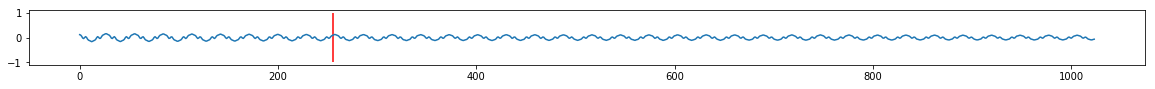

2019-01-27 17:45:01 Epoch [0/1], Step [15850/121875] Loss: 1.3575
2019-01-27 17:46:18 Epoch [0/1], Step [15900/121875] Loss: 1.3223
2019-01-27 17:47:35 Epoch [0/1], Step [15950/121875] Loss: 1.2888
2019-01-27 17:48:52 Epoch [0/1], Step [16000/121875] Loss: 1.3226


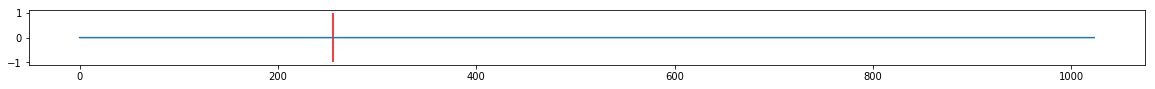

model 2019-01-27_10-43-18_model_epoch0_step16000.tar saved
model 2019-01-27_10-43-18_model_epoch0_step16001.tar saved
Training time taken: 7:05:41


In [7]:
# Train!
#*************************************
if not loadTrainingParams:
    start = '{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now())
print('{:%Y-%m-%d %H:%M:%S} Starting training at epoch{} step{}...'.format(datetime.now(),start_epoch,start_step))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(model,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel: #!NOTE the naming scheme for this saving part in still incorrect (for steps) 
    torch.save({#the checkpoint_dict here is slightly different from above since it can't access some local variables in training
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': list_of_losses,
                            'epoch': start_epoch+epoch,
                            'step': start_step,
                            'sample_rate': sr,
                            'start_time': start,
                            'datadir': datadir,
                            'paramdir': paramdir,
                            'savemodeldir': savemodeldir,
                            'seqLen': seqLen,
                            'stride': stride,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'lr': lr,
                            'log_interval': log_interval,
                            'max_steps': max_steps,
                            'teacher_forcing_ratio': teacher_forcing_ratio,                    
                            'prop': prop,
                            'output_size': output_size,
                            'hidden_size': hidden_size,
                            'n_layers': n_layers,
                            'noise': noise,
                            'lowNote': lowNote,
                            'hiNote': hiNote
                },                            
                    '{}/{}_{}_epoch{}_step{}.tar'.format(
                        savemodeldir,start,savename,start_epoch+epoch,start_step))
    print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step))
    
if savemodel_interval == num_epochs: #!NOTE the naming scheme for this saving part in still incorrect (for steps) 
    torch.save({#the checkpoint_dict here is slightly different from above since it can't access some local variables in training
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': list_of_losses,
                            'epoch': start_epoch+epoch,
                            'step': start_step,
                            'sample_rate': sr,
                            'start_time': start,
                            'datadir': datadir,
                            'paramdir': paramdir,
                            'savemodeldir': savemodeldir,
                            'seqLen': seqLen,
                            'stride': stride,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'lr': lr,
                            'log_interval': log_interval,
                            'max_steps': max_steps,
                            'teacher_forcing_ratio': teacher_forcing_ratio,                    
                            'prop': prop,
                            'output_size': output_size,
                            'hidden_size': hidden_size,
                            'n_layers': n_layers,
                            'noise': noise,
                            'lowNote': lowNote,
                            'hiNote': hiNote
                },                            
                    '{}/{}_{}_epoch{}_step{}.tar'.format(
                        savemodeldir,start,savename,start_epoch+epoch,start_step))
    print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step))

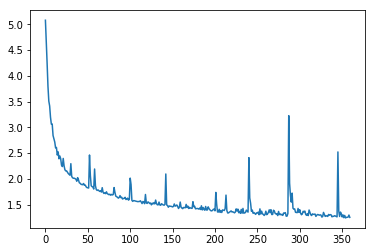

In [8]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)